In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm
import scikit_posthocs as sp

pd.set_option('display.max_columns', 9999)

%matplotlib inline

### Data Import and Cleaning

In [2]:
pts = pd.read_csv('eicu-collaborative-research-database-2.0/patient.csv.gz')
hos = pd.read_csv('eicu-collaborative-research-database-2.0/hospital.csv.gz')

In [3]:
# finding all opioids and nsaids given to patients

opioids = ['hydromorphone','hydrocodone','morphine','oxycodone','oxymorphone','codeine','fentanyl','meperidine',
          'tramadol','carfentanil','percocet','norco']

nsaids = ['acetaminophen','amitriptyline', 'doxepin', 'imipramine', 'desipramine', 'nortriptyline',
         'ibuprofen', 'naproxen', 'diclofenac', 'piroxicam', 'sulindac', 'indomethacin', 'ketorolac', 'meloxicam', 
          'celecoxib', 'ketoprofen', 'oxaprozin', 'toradol', 'valdecoxib', 'bextra', 'rofecoxib', 'vioxx', 'gabapentin', 
          'neurontin', 'cyclobenzaprine', 'duloxetine', 'cymbalta', 'pregabalin', 'lyrica', 'venlafaxine', 'effexor', 
          'tylenol', 'voltaren', 'naprosyn', 'paracetamol', 'aspirin']

def opioids_nsaids (x, li):

    for i in li:
        if i in str(x).lower():
            return 1
        
    return 0

def op_find (x, arr):
    try:
        return arr['opioid'][x]
    except:
        return np.nan
    
def nsaid_find (x, arr):
    try:
        return arr['nsaid'][x]
    except:
        return np.nan

In [4]:
med = pd.read_csv('eicu-collaborative-research-database-2.0/medication.csv.gz')
med = med[med.drugordercancelled == 'No']

cols_drop = ['medicationid',
             'drugorderoffset',
             'drugivadmixture',
             'drugordercancelled',
             'drughiclseqno',
             'routeadmin',
             'loadingdose',
             'prn',
             'gtc'
            ]

med.drop(columns=cols_drop, inplace=True)

med['opioid'] = med.drugname.apply(lambda x: opioids_nsaids(x, opioids))
med['nsaid'] = med.drugname.apply(lambda x: opioids_nsaids(x, nsaids))

med = med[(med.opioid == 1) | (med.nsaid == 1)]

mg = med.groupby(['patientunitstayid']).agg({'opioid': lambda x:sum(x), 'nsaid': lambda x:sum(x)})
mg[mg != 0] = 1

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
pts = pts[pts.gender != 'Unknown']
pts = pts[pts.gender != 'Other']

pts['opioid'] = pts['patientunitstayid'].apply(lambda x: op_find(x, mg))
pts['nsaid'] = pts['patientunitstayid'].apply(lambda x: nsaid_find(x, mg))

pts = pd.merge(pts, hos, on=['hospitalid'], how = 'left')

In [6]:
# fill missing values

pts['apacheadmissiondx'].fillna(value = 'N/A', inplace = True)
pts['hospitaladmitsource'].fillna(value = 'Unknown', inplace = True)

def age (x):
    if x == '> 89':
        return 90
    else:
        return int(x)

pts['age'].fillna(value = 0, inplace = True)
pts['age'] = pts['age'].apply(lambda x: age(x))

pts.opioid.fillna(0, inplace = True)
pts.nsaid.fillna(0, inplace = True)

pts.opioid.replace(1.0,True,inplace=True)
pts.opioid.replace(0.0,False,inplace=True)

pts.nsaid.replace(1.0,True,inplace=True)
pts.nsaid.replace(0.0,False,inplace=True)

pts['painmeds'] = pts.opioid|pts.nsaid

In [7]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid,nsaid,numbedscategory,teachingstatus,region,painmeds
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851,True,True,<100,f,Midwest,True
1,141178,128927,Female,52,Caucasian,60,83,N/A,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870,False,True,<100,f,Midwest,True
2,141179,128927,Female,52,Caucasian,60,83,N/A,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870,False,False,<100,f,Midwest,False
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276,True,True,>= 500,t,Midwest,True
4,141196,128943,Male,71,Caucasian,67,109,N/A,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665,True,True,NaN,f,Midwest,True


### Feature Engineering

In [8]:
# morphine equivalence

opi = pd.read_csv('opioids_final.csv')
opi = opi[['patientunitstayid','mme_per_day']]

pts = pd.merge(pts, opi, on=['patientunitstayid'], how = 'left')

In [9]:
#apache score

apache = pd.read_csv('eicu-collaborative-research-database-2.0/apachePatientResult.csv.gz')

apache = apache[apache['apacheversion']=='IV']
apache_scores = apache[['patientunitstayid','apachescore','actualventdays']]
pts = pd.merge(pts, apache_scores, on=['patientunitstayid'], how = 'right')

In [10]:
# gcs score

gcs = pd.read_csv('eicu-collaborative-research-database-2.0/apachePredVar.csv.gz')

gcs = gcs[['patientunitstayid','verbal', 'motor', 'eyes']]
gcs['gcs_score'] = gcs['verbal'] + gcs['motor'] + gcs['eyes']
gcs = gcs[['patientunitstayid', 'gcs_score']]

pts = pd.merge(pts, gcs, on=['patientunitstayid'], how = 'right')

In [11]:
# admission from the OR

pts['from_OR'] = pts['unitadmitsource'] == 'Operating Room'

In [12]:
# admission heart rate

first_values = pd.read_csv('heartrate2.csv')
pts = pd.merge(pts, first_values, on=['patientunitstayid'], how = 'right')

In [13]:
# days in the ICU

pts['ICU_duration'] = (pts['unitdischargeoffset'] - pts['hospitaladmitoffset'])/1440

In [14]:
# pain scores

pain = pd.read_csv('pain.csv')
pts = pd.merge(pts, pain, on=['patientunitstayid'], how = 'right')

In [15]:
pts['pain_change'] = pts.finalPain - pts.initialPain

In [16]:
# BMI

pts = pts[(pts.admissionheight > 100)]
pts = pts[(pts.admissionweight > 0) & (pts.admissionweight < 200)]

pts['admissionheight'] = pts['admissionheight'].replace(0, pts['admissionheight'].median())
pts['admissionweight'] = pts['admissionweight'].replace(0, pts['admissionweight'].median())

pts['BMI'] = (pts.admissionweight/pts.admissionheight/pts.admissionheight)*10000

In [17]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid,nsaid,numbedscategory,teachingstatus,region,painmeds,mme_per_day,apachescore,actualventdays,gcs_score,from_OR,Unnamed: 1,heartrate,hr_over100,ICU_duration,initialPain,finalPain,pain_change,BMI
0,141168,128919.0,Female,70.0,Caucasian,59.0,91.0,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0.0,Direct Admit,2015.0,03:50:00,3596.0,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1.0,admit,84.3,85.8,03:50:00,3596.0,Death,Expired,002-34851,True,True,<100,f,Midwest,True,1728.00,65.0,NaN,15.0,False,15.0,140.0,True,2.497222,0,0,0,36.295906
1,141194,128941.0,Male,68.0,Caucasian,73.0,92.0,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780.0,Floor,2015.0,23:30:00,12492.0,Home,Alive,CTICU,07:18:00,Floor,1.0,admit,73.9,76.7,15:31:00,4813.0,Floor,Alive,002-5276,True,True,>= 500,t,Midwest,True,140.30,70.0,NaN,13.0,False,1638.0,112.0,True,3.884028,0,0,0,22.732803
2,141208,128952.0,Female,25.0,Caucasian,73.0,93.0,"Overdose, sedatives, hypnotics, antipsychotics...",172.7,11:23:00,-1.0,Emergency Department,2015.0,21:30:00,606.0,Other Hospital,Alive,Med-Surg ICU,11:24:00,Emergency Department,1.0,admit,95.3,95.3,23:24:00,720.0,Home,Alive,002-34521,False,True,>= 500,t,Midwest,True,NaN,17.0,NaN,14.0,False,2559.0,83.0,False,0.500694,4,4,0,31.952749
3,141227,128968.0,Male,82.0,Caucasian,60.0,83.0,"Sepsis, pulmonary",185.4,19:19:00,-1004.0,Floor,2015.0,16:35:00,1712.0,Other Hospital,Alive,Med-Surg ICU,12:03:00,Floor,1.0,admit,82.2,82.2,15:35:00,1652.0,Other Hospital,Alive,002-21459,True,True,<100,f,Midwest,True,3.50,100.0,2.0,13.0,False,2728.0,112.0,True,1.844444,0,0,0,23.914007
4,141233,128973.0,Female,81.0,Caucasian,73.0,92.0,Mitral valve replacement,165.1,17:27:13,-1.0,Operating Room,2015.0,15:48:00,22940.0,Home,Alive,CTICU,17:28:00,Operating Room,1.0,admit,61.7,73.2,14:53:00,15685.0,Floor,Alive,002-8979,True,True,>= 500,t,Midwest,True,343.68,66.0,2.0,15.0,True,4152.0,100.0,True,10.893056,0,0,0,22.635548


### Missing Values, etc.

In [18]:
pts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58542 entries, 0 to 62089
Data columns (total 48 columns):
patientunitstayid            58542 non-null int64
patienthealthsystemstayid    58542 non-null float64
gender                       58539 non-null object
age                          58542 non-null float64
ethnicity                    57726 non-null object
hospitalid                   58542 non-null float64
wardid                       58542 non-null float64
apacheadmissiondx            58542 non-null object
admissionheight              58542 non-null float64
hospitaladmittime24          58542 non-null object
hospitaladmitoffset          58542 non-null float64
hospitaladmitsource          58542 non-null object
hospitaldischargeyear        58542 non-null float64
hospitaldischargetime24      58542 non-null object
hospitaldischargeoffset      58542 non-null float64
hospitaldischargelocation    58542 non-null object
hospitaldischargestatus      58542 non-null object
unittype         

In [19]:
pts.drop(columns=['Unnamed: 1'], inplace=True)

In [20]:
pts.actualventdays.fillna(value=0, inplace=True)

In [21]:
pts.mme_per_day.fillna(0.0,inplace=True)

In [22]:
pts["painmeds"] = pts["painmeds"].astype(int)
pts["opioid"] = pts["opioid"].astype(int)
pts["nsaid"] = pts["nsaid"].astype(int)
pts["from_OR"] = pts["from_OR"].astype(int)

pts.teachingstatus.replace('t', 1, inplace=True)
pts.teachingstatus.replace('f', 0, inplace=True)

pts.gender.replace('Male', 1, inplace=True)
pts.gender.replace('Female', 0, inplace=True)

In [23]:
pts_final = pts.dropna()

In [24]:
pts_final.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid,nsaid,numbedscategory,teachingstatus,region,painmeds,mme_per_day,apachescore,actualventdays,gcs_score,from_OR,heartrate,hr_over100,ICU_duration,initialPain,finalPain,pain_change,BMI
0,141168,128919.0,0.0,70.0,Caucasian,59.0,91.0,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0.0,Direct Admit,2015.0,03:50:00,3596.0,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1.0,admit,84.3,85.8,03:50:00,3596.0,Death,Expired,002-34851,1,1,<100,0,Midwest,1,1728.00,65.0,0.0,15.0,0,140.0,True,2.497222,0,0,0,36.295906
1,141194,128941.0,1.0,68.0,Caucasian,73.0,92.0,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780.0,Floor,2015.0,23:30:00,12492.0,Home,Alive,CTICU,07:18:00,Floor,1.0,admit,73.9,76.7,15:31:00,4813.0,Floor,Alive,002-5276,1,1,>= 500,1,Midwest,1,140.30,70.0,0.0,13.0,0,112.0,True,3.884028,0,0,0,22.732803
2,141208,128952.0,0.0,25.0,Caucasian,73.0,93.0,"Overdose, sedatives, hypnotics, antipsychotics...",172.7,11:23:00,-1.0,Emergency Department,2015.0,21:30:00,606.0,Other Hospital,Alive,Med-Surg ICU,11:24:00,Emergency Department,1.0,admit,95.3,95.3,23:24:00,720.0,Home,Alive,002-34521,0,1,>= 500,1,Midwest,1,0.00,17.0,0.0,14.0,0,83.0,False,0.500694,4,4,0,31.952749
3,141227,128968.0,1.0,82.0,Caucasian,60.0,83.0,"Sepsis, pulmonary",185.4,19:19:00,-1004.0,Floor,2015.0,16:35:00,1712.0,Other Hospital,Alive,Med-Surg ICU,12:03:00,Floor,1.0,admit,82.2,82.2,15:35:00,1652.0,Other Hospital,Alive,002-21459,1,1,<100,0,Midwest,1,3.50,100.0,2.0,13.0,0,112.0,True,1.844444,0,0,0,23.914007
4,141233,128973.0,0.0,81.0,Caucasian,73.0,92.0,Mitral valve replacement,165.1,17:27:13,-1.0,Operating Room,2015.0,15:48:00,22940.0,Home,Alive,CTICU,17:28:00,Operating Room,1.0,admit,61.7,73.2,14:53:00,15685.0,Floor,Alive,002-8979,1,1,>= 500,1,Midwest,1,343.68,66.0,2.0,15.0,1,100.0,True,10.893056,0,0,0,22.635548


In [25]:
pts_select = pts_final[['patientunitstayid',
                 'gender', 
                 'age', 
                 'ethnicity',
                 'BMI', 
                 'actualventdays',
                 'ICU_duration',
                 'gcs_score', 
                 'apachescore', 
                 'from_OR',
                 'heartrate',
                 'hospitaldischargestatus',
                 'teachingstatus',
                 'region',
                 'numbedscategory',
                 'opioid', 
                 'nsaid',
                 'painmeds',
                 'mme_per_day',
                 'initialPain',
                 'finalPain',
                 'pain_change']]

### Data Export

In [ ]:
pts_final.to_csv('data/pts_final.csv')

In [26]:
pts_select.to_csv('data/pts_no_dummies.csv')

In [27]:
pts_select = pd.get_dummies(pts_select, columns = ['numbedscategory','ethnicity', 'region'], drop_first = False)
pts_select = pd.get_dummies(pts_select, columns = ['hospitaldischargestatus'], drop_first = True)

In [28]:
pts_select.to_csv('data/pts_dummies.csv')

### Modeling

In [29]:
one_hot = pd.read_csv('data/pts_dummies.csv')
one_hot.drop(columns=['Unnamed: 0'], inplace=True)

In [30]:
one_hot = one_hot[(one_hot.mme_per_day < 1000)]
one_hot = one_hot[(one_hot.mme_per_day >= 0)]

In [31]:
one_hot.head()

,patientunitstayid,gender,age,BMI,actualventdays,ICU_duration,gcs_score,apachescore,from_OR,heartrate,teachingstatus,opioid,nsaid,painmeds,mme_per_day,initialPain,finalPain,pain_change,numbedscategory_100 - 249,numbedscategory_250 - 499,numbedscategory_<100,numbedscategory_>= 500,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,region_Midwest,region_Northeast,region_South,region_West,hospitaldischargestatus_Expired
1,141194,1.0,68.0,22.732803,0.0,3.884028,13.0,70.0,0,112.0,1,1,1,1,140.30,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
2,141208,0.0,25.0,31.952749,0.0,0.500694,14.0,17.0,0,83.0,1,0,1,1,0.00,4,4,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
3,141227,1.0,82.0,23.914007,2.0,1.844444,13.0,100.0,0,112.0,0,1,1,1,3.50,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
4,141233,0.0,81.0,22.635548,2.0,10.893056,15.0,66.0,1,100.0,1,1,1,1,343.68,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
5,141244,1.0,59.0,28.392932,0.0,10.679861,15.0,28.0,1,108.0,1,1,1,1,180.40,9,0,-9,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0


In [60]:
one_hot.shape

(40430, 33)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from matplotlib.legend_handler import HandlerLine2D

#### Opioid Administration (Yes/No)

In [33]:
X = one_hot.drop(columns=['opioid','painmeds','mme_per_day', 'patientunitstayid'])
y = one_hot.opioid

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
from sklearn.model_selection import GridSearchCV

param2 = {"max_features":["log2","sqrt", None]}

grid2 = GridSearchCV(GradientBoostingClassifier(learning_rate=0.05, max_depth=5.0, n_estimators=200, subsample=1.0), param2, scoring='roc_auc', n_jobs=-1, cv=3)
grid2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  max_depth=5.0,
                                                  n_estimators=200),
             n_jobs=-1, param_grid={'max_features': ['log2', 'sqrt', None]},
             scoring='roc_auc')

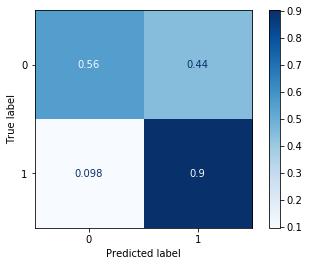

In [35]:
y_pred = grid2.predict(X_test)
metrics.plot_confusion_matrix(grid2, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')
plt.savefig('figs_rev/cm_opioid.png', dpi=300)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.56      0.64      1458
           1       0.78      0.90      0.84      2585

    accuracy                           0.78      4043
   macro avg       0.77      0.73      0.74      4043
weighted avg       0.78      0.78      0.77      4043



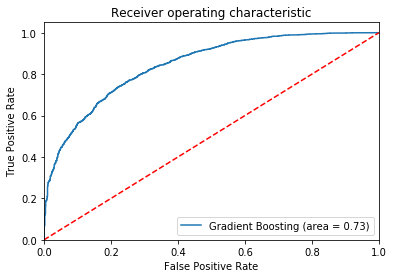

<Figure size 432x288 with 0 Axes>

In [37]:
logit_roc_auc = roc_auc_score(y_test, grid2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, grid2.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
plt.savefig('figs_rev/roc_opioid.png', dpi=300)

#### MME per Day (Continuous)

In [53]:
X = one_hot.drop(columns=['painmeds','mme_per_day','patientunitstayid'])
y = one_hot.mme_per_day

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

In [55]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=0)
rf.fit(X_train, y_train)

r2 = rf.score(X_test, y_test)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)

print('rmse:', rmse, '| r2 score:', r2)

rmse: 87.35524466235535 | r2 score: 0.3247909750127631


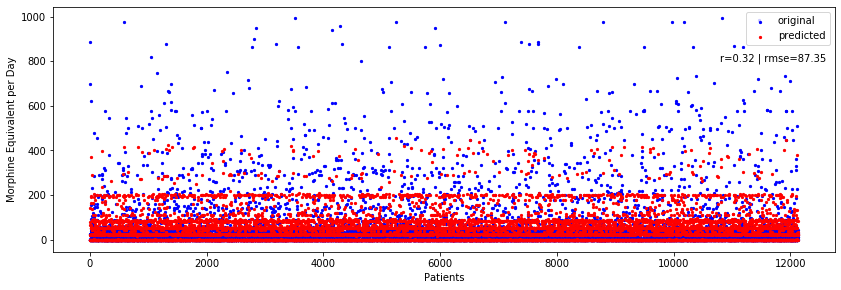

In [56]:
plt.figure(figsize=(14, 4.5))
x_ax = range(len(y_pred))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.scatter(x_ax, y_pred, s=5, color="red", label="predicted")
plt.text(10800, 800, r'r^2=0.32 | rmse=87.35', backgroundColor='white')
plt.legend()
plt.xlabel('Patients')
plt.ylabel('Morphine Equivalent per Day')
plt.savefig('figs_rev/patient_mme_pred.png',dpi=300)

### Pain Change

In [81]:
X = one_hot.drop(columns=['finalPain','pain_change','patientunitstayid'])
y = one_hot.pain_change

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#scaler = MinMaxScaler()

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [82]:
# Gradient Boosting

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.25, max_depth=5, random_state=0)
model.fit(X_train, y_train)

r2 = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)

print('rmse:', rmse, '| r2 score:', r2)

rmse: 2.6954371453723525 | r2 score: 0.4294792443943035


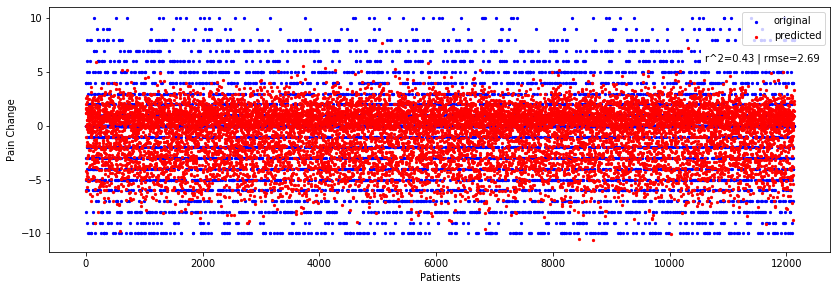

In [83]:
plt.figure(figsize=(14, 4.5))
x_ax = range(len(y_pred))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.scatter(x_ax, y_pred, s=5, color="red", label="predicted")
plt.text(10600, 6, r'r^2=0.43 | rmse=2.69', backgroundColor='white')
plt.legend()
plt.xlabel('Patients')
plt.ylabel('Pain Change')
plt.savefig('figs_rev/patient_pain_change.png',dpi=300)

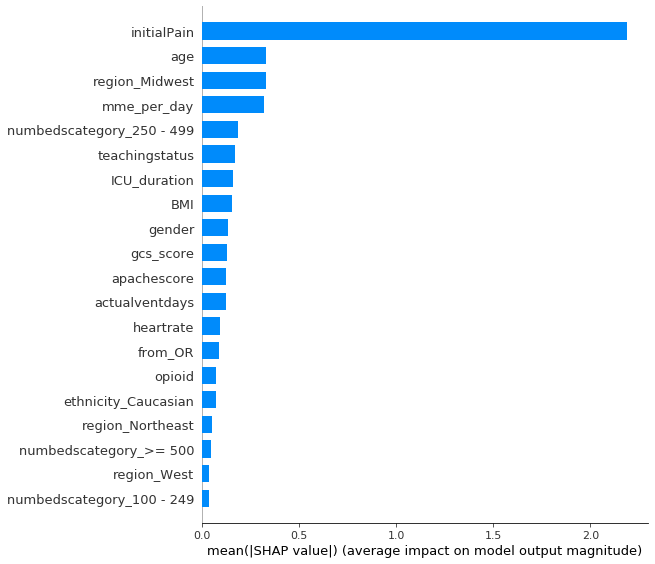

In [87]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.savefig('figs_rev/shap_pain.png',dpi=300, bbox_inches='tight')

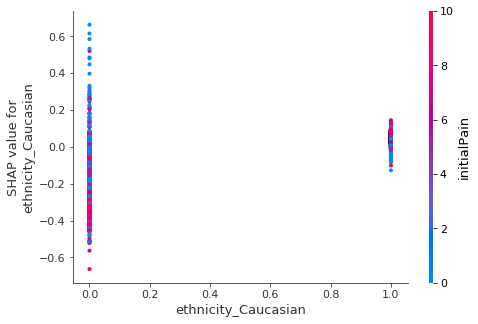

In [88]:
shap.dependence_plot('ethnicity_Caucasian', shap_values, X_train)

### Figures

In [43]:
pts_figs = pd.read_csv('data/pts_no_dummies.csv')
pts_figs.head()

,Unnamed: 0,patientunitstayid,gender,age,ethnicity,BMI,actualventdays,ICU_duration,gcs_score,apachescore,from_OR,heartrate,hospitaldischargestatus,teachingstatus,region,numbedscategory,opioid,nsaid,painmeds,mme_per_day,initialPain,finalPain,pain_change
0,0,141168,0.0,70.0,Caucasian,36.295906,0.0,2.497222,15.0,65.0,0,140.0,Expired,0,Midwest,<100,1,1,1,1728.00,0,0,0
1,1,141194,1.0,68.0,Caucasian,22.732803,0.0,3.884028,13.0,70.0,0,112.0,Alive,1,Midwest,>= 500,1,1,1,140.30,0,0,0
2,2,141208,0.0,25.0,Caucasian,31.952749,0.0,0.500694,14.0,17.0,0,83.0,Alive,1,Midwest,>= 500,0,1,1,0.00,4,4,0
3,3,141227,1.0,82.0,Caucasian,23.914007,2.0,1.844444,13.0,100.0,0,112.0,Alive,0,Midwest,<100,1,1,1,3.50,0,0,0
4,4,141233,0.0,81.0,Caucasian,22.635548,2.0,10.893056,15.0,66.0,1,100.0,Alive,1,Midwest,>= 500,1,1,1,343.68,0,0,0


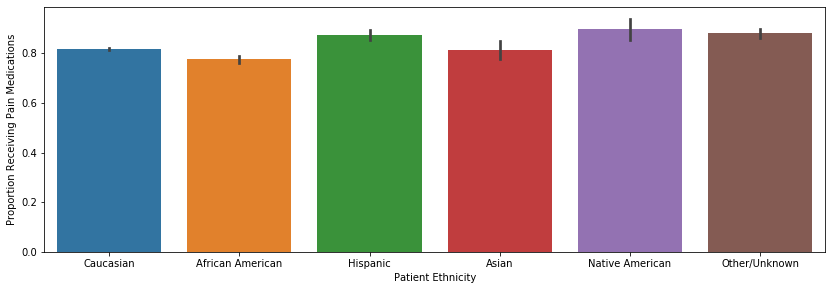

In [44]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='painmeds',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Pain Medications')
plt.savefig('figs_rev/ethnicity_painmeds.png',dpi=300)

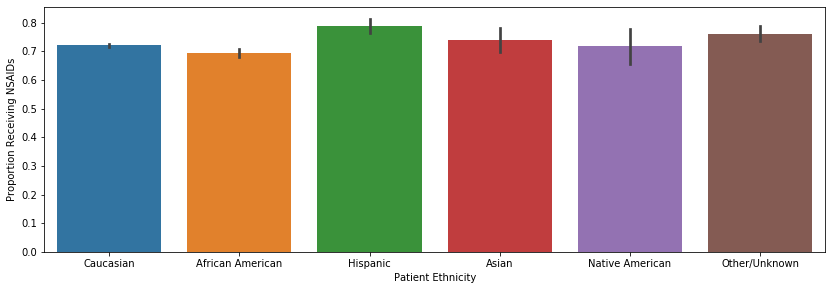

In [45]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='nsaid',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving NSAIDs')
plt.savefig('figs_rev/ethnicity_nsaids.png',dpi=300)

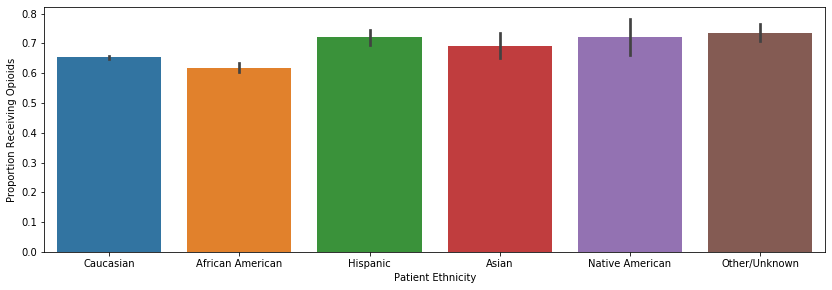

In [46]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='opioid',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Opioids')
plt.savefig('figs_rev/ethnicity_opioids.png',dpi=300)

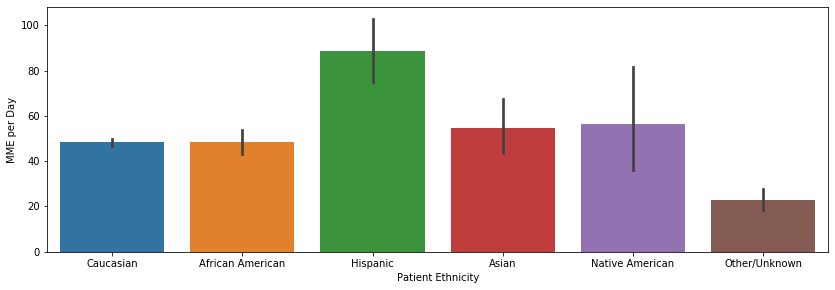

In [47]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='mme_per_day',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('MME per Day')
plt.savefig('figs_rev/ethnicity_mme.png',dpi=300)

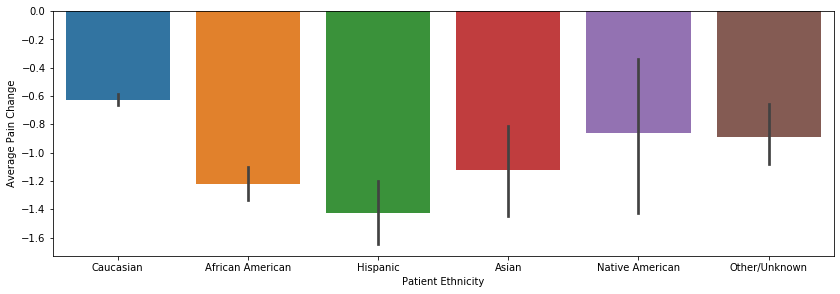

In [48]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='pain_change',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Average Pain Change')
plt.savefig('figs_rev/ethnicity_painchange.png',dpi=300)

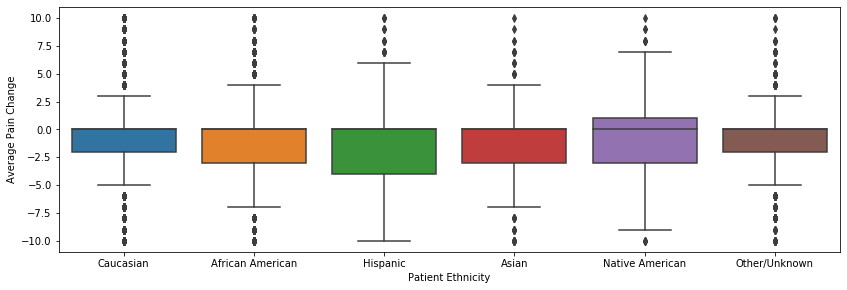

In [72]:
plt.figure(figsize=(14, 4.5))
sns.boxplot(x='ethnicity',y='pain_change',data=pts_figs)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Average Pain Change')
plt.savefig('figs_rev/ethnicity_painchange_box.png',dpi=300)

### Significance

In [57]:
# Testing for Normal Distribution

pts_figs_c = list(pts_figs[pts_figs.ethnicity == 'Caucasian'].pain_change)
pts_figs_aa = list(pts_figs[pts_figs.ethnicity == 'African American'].pain_change)
pts_figs_a = list(pts_figs[pts_figs.ethnicity == 'Asian'].pain_change)
pts_figs_h = list(pts_figs[pts_figs.ethnicity == 'Hispanic'].pain_change)
pts_figs_na = list(pts_figs[pts_figs.ethnicity == 'Native American'].pain_change)
pts_figs_o = list(pts_figs[pts_figs.ethnicity == 'Other/Unknown'].pain_change)

k_c, p_c = stat.kstest(pts_figs_c, 'norm')
k_aa, p_aa = stat.kstest(pts_figs_aa, 'norm')
k_a, p_a = stat.kstest(pts_figs_a, 'norm')
k_h, p_h = stat.kstest(pts_figs_h, 'norm')
k_na, p_na = stat.kstest(pts_figs_na, 'norm')
k_o, p_o = stat.kstest(pts_figs_o, 'norm')

print('Caucasian: k-value:', k_c, 'p-value:', p_c)
print('African America: k-value:', k_aa, 'p-value:', p_aa)
print('Asian: k-value:', k_a, 'p-value:', p_a)
print('Hispanic: k-value:', k_h, 'p-value:', p_h)
print('Native American: k-value:', k_na, 'p-value:', p_na)
print('Other: k-value:', k_o, 'p-value:', p_o)

Caucasian: k-value: 0.2799085707713982 p-value: 0.0
African America: k-value: 0.33226837060702874 p-value: 0.0
Asian: k-value: 0.33564814814814814 p-value: 6.651005957481511e-44
Hispanic: k-value: 0.34918347742555234 p-value: 5.9296916579898136e-114
Native American: k-value: 0.3307852215871743 p-value: 8.319776346325207e-20
Other: k-value: 0.3463886063072228 p-value: 7.131656472430345e-106


In [76]:
from bioinfokit.analys import stat

res = stat()
res.anova_stat(df=pts_figs, res_var='ethnicity', anova_model='pain_change ~ C(ethnicity)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(ethnicity),5.0,1861.536135,372.307227,29.315195,8.098997e-30
Residual,41185.0,523055.465297,12.700145,NaN,NaN


The p-value obtained from ANOVA analysis is significant (p < 0.05), we conclude there are significant differences between ethnicities.